# Feature Engineering and Selection

***
**Author:** Jiacheng

**Create Time:**  2020-01-06

**Update Time:**  2020-01-09
***

## [0. EDA](#0.EDA)
## [1. 特征工程 (Feature Engineering)](#一、特征工程)
## [2. 特征选择 (Feature Selection)](#二、特征选择)

In [1]:
# 导入所需模块
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 数据载入
data_train = pd.read_csv('./Data_Set/train_data.csv')
data_test = pd.read_csv('./Data_Set/test_a.csv')

data_train['Type'] = 'Train'
data_test['Type'] = 'Test'

data_all = pd.concat([data_train, data_test], ignore_index=True)

print ("Train: ",data_train.shape[0],"sales, and ",data_train.shape[1],"features")
print ("Test: ",data_test.shape[0],"sales, and ",data_test.shape[1],"features")

Train:  41440 sales, and  52 features
Test:  2469 sales, and  51 features


## 0.EDA

我们将之前EDA的函数整合，用来处理原始数据，随后再进行特征工程

In [3]:
def preprocessingData(df):
    # 删除无关字段
    df.drop("city", axis=1, inplace=True)
    df.drop("ID", axis=1, inplace=True)
    
    # 转换object
#     columns = ['rentType','communityName','houseType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate']
#     for feature in columns:
#         df[feature] = LabelEncoder().fit_transform(df[feature])
    
    # pv、uv填充
    df['pv'].fillna(df['pv'].mean(), inplace=True)
    df['uv'].fillna(df['uv'].mean(), inplace=True)
    # 浏览人数为整数
    df['pv'] = df['pv'].astype('int')
    df['uv'] = df['uv'].astype('int')
    
    # rentType转换
    df['rentType'][df['rentType'] == '--'] = '未知方式'
    
    # buildYear处理
    buildYearMode = pd.DataFrame(df[df['buildYear'] != '暂无信息']['buildYear'].mode())
    df.loc[df[df['buildYear'] == '暂无信息'].index, 'buildYear'] = buildYearMode.iloc[0, 0]
    df['buildYear'] = df['buildYear'].astype('int')
    
    # 分割交易时间
    # 年份相同，丢弃
    df['month'] = df['tradeTime'].apply(lambda x: x.split('/')[1]).astype('int')
    df['day'] = df['tradeTime'].apply(lambda x: x.split('/')[2]).astype('int')
    df.drop('tradeTime', axis=1, inplace=True)
    
    return df

In [4]:
def cleanData(df):
    # 孤立森林处理
    def IF_drop(df):
        IForest = IsolationForest(contamination=0.01)
        IForest.fit(df["tradeMoney"].values.reshape(-1,1))
        y_pred = IForest.predict(df["tradeMoney"].values.reshape(-1,1))
        drop_index = df.loc[y_pred==-1].index
        
        df.drop(drop_index,inplace=True)
        return df

    df = IF_drop(df)
    
    # 异常值处理
    df = df[df.area<=200]
    df.drop(df[(df['totalFloor'] == 0)].index, inplace=True)
    df = df[(df.tradeMoney <=16000) & (df.tradeMoney >=500)]
    
    # 深度清洗
    def DeepClean(data):
        data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<=1000)&(data['area']>=50)].index,inplace=True)
        data.drop(data[(data['region']=='RG00002') & (data['tradeMoney']>60000)&(data['area']<100)].index,inplace=True)
        data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>30000)&(data['area']<300)].index,inplace=True)
        data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
        data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
        data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
        data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True) 
        data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
        data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>20000)&(data['area']>400)].index,inplace=True)
        data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
        data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
        data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
        data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
        data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
        data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
        data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
        data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
        data.drop(data[(data['region']=='RG00006') & (data['area']>165)].index,inplace=True)
        data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
        data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<2000)&(data['area']>200)].index,inplace=True)
        data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<2500)&(data['area']>100)].index,inplace=True)
        data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
        data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
        data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
        data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
        data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
        data.drop(data[(data['region']=='RG00008') & (data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
        data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
        data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
        data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']<2000)&(data['area']>100)].index,inplace=True)
        data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
        data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<15000)&(data['area']>400)].index,inplace=True)
        data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
        data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
        data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
        data.drop(data[(data['region']=='RG00011') & (data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
        data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<5000)&(data['area']>120)].index,inplace=True)
        data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
        data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)   
        data.drop(data[(data['region']=='RG00013') & (data['tradeMoney']>40000)&(data['area']<100)].index,inplace=True)
        data.drop(data[(data['region']=='RG00013') & (data['tradeMoney']>50000)&(data['area']>400)].index,inplace=True)
        data.drop(data[(data['region']=='RG00013') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
        data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>40000)&(data['area']>300)].index,inplace=True)
        data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
        data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
        data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
        data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
        data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
        data.drop(data[(data['region']=='RG00015') ].index,inplace=True)
        
        data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
        data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
        
        data.reset_index(drop=True, inplace=True)        
        return data
    
    df = DeepClean(df)
    
    return df

In [5]:
data_train = preprocessingData(data_train)
data_test = preprocessingData(data_test)

data_train = cleanData(data_train)

print ("Train: ",data_train.shape[0],"sales, and ",data_train.shape[1],"features")
print ("Test: ",data_test.shape[0],"sales, and ",data_test.shape[1],"features")

Train:  40160 sales, and  51 features
Test:  2469 sales, and  50 features


In [6]:
data_train.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,Type,month,day
0,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,RG00001,BK00064,...,28248,614,111546,1124,284,0,2000.0,Train,11,28
1,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,RG00002,BK00049,...,14823,148,157552,701,22,1,2000.0,Train,12,16
2,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,RG00002,BK00050,...,77645,520,131744,57,20,1,16000.0,Train,12,22
3,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,RG00002,BK00051,...,8750,1665,253337,888,279,9,1600.0,Train,12,21
4,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,RG00003,BK00044,...,800,117,125309,2038,480,0,2900.0,Train,11,18


In [7]:
data_test.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,Type,month,day
0,36.54,未知方式,1室1厅1卫,高,21,西北,其他,XQ03867,RG00012,BK00013,...,0.0,41503,319,301635,1601,397,2,Test,10,25
1,64.00,未知方式,2室1厅1卫,高,11,南北,其他,XQ00821,RG00002,BK00055,...,0.0,4370,0,306857,21123,3066,0,Test,8,19
2,98.00,未知方式,3室1厅1卫,高,6,暂无数据,精装,XQ00842,RG00002,BK00055,...,0.0,4370,0,306857,17471,2554,0,Test,3,4
3,43.45,未知方式,1室1厅1卫,高,6,暂无数据,其他,XQ00786,RG00002,BK00055,...,0.0,4370,0,306857,19231,2016,0,Test,2,3
4,92.00,未知方式,2室2厅1卫,高,6,暂无数据,其他,XQ01201,RG00002,BK00062,...,4536.0,20904,0,245872,26189,2957,0,Test,3,14


## 一、特征工程

数据处理完毕，接下来可以构造一下新的特征  
选择部分特征用热图查看一下相关性  

### [分析判断](#分析判断)    
### [整合函数](#整合函数)

### 分析判断
先用简单的语法，生成整理、判断一些特征，最后再整合为函数

In [8]:
# 数据载入
train = data_train.copy()
test = data_test.copy()

#### rentType再生成
前面我们已经判断 rentType 大多数为‘未知方式’，我们不妨用已知数据加主观判断确定一下部分未知的rentType

In [12]:
train['Room'] = train['houseType'].apply(lambda x: x.split('室')[0]).astype('int')
train['Hall'] = train['houseType'].apply(lambda x: x.split('室')[1].split('厅')[0]).astype('int') 
train['Bath'] = train['houseType'].apply(lambda x: x.split("室")[1].split("厅")[1].split("卫")[0]).astype('int')
train['Room_Bath'] = (train['Bath']+1) / (train['Room']+1)
train.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,uv,lookNum,tradeMoney,Type,month,day,Room,Hall,Bath,Room_Bath
0,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,RG00001,BK00064,...,284,0,2000.0,Train,11,28,2,1,1,0.666667
1,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,RG00002,BK00049,...,22,1,2000.0,Train,12,16,3,2,2,0.750000
2,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,RG00002,BK00050,...,20,1,16000.0,Train,12,22,3,2,2,0.750000
3,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,RG00002,BK00051,...,279,9,1600.0,Train,12,21,1,1,1,1.000000
4,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,RG00003,BK00044,...,480,0,2900.0,Train,11,18,3,2,3,1.000000


画图看看rentType与area、tradeMoney、Room_Bath的关系

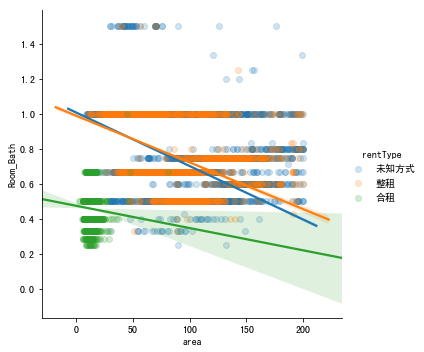

In [20]:
sns.lmplot('area', 'Room_Bath', data=train, hue='rentType', scatter_kws={'alpha':0.2})

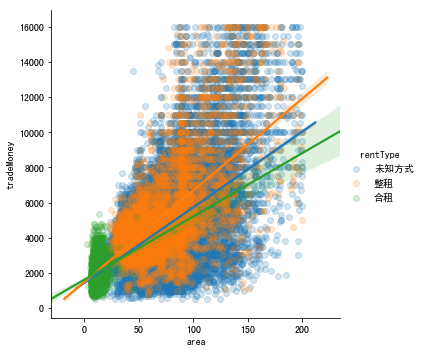

In [21]:
sns.lmplot('area', 'tradeMoney', data=train, hue='rentType', scatter_kws={'alpha':0.2})

这张图一看就想聚类或者SVM啊

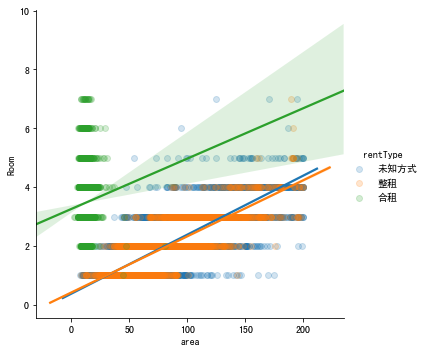

In [25]:
sns.lmplot('area', 'Room', data=train, hue='rentType', scatter_kws={'alpha':0.2})

emmmm, 有点出乎意料  
合租房子的面积基本小于50，（厕所/房间数）基本小于1，价格小于6000  
据此可以判断写未知方式

先调用SVM判断可行吗？？？  
试一试 

In [56]:
from sklearn.svm import SVC

In [67]:
train['id'] = [i for i in range(train.shape[0])]
SVM_all = pd.DataFrame(train[['id', 'area', 'tradeMoney', 'Room', 'Room_Bath', 'rentType']])
SVM_train = SVM_all[SVM_all['rentType'] != '未知方式']
SVM_test = SVM_all[SVM_all['rentType'] == '未知方式']
SVM_train_x = np.array(SVM_train.iloc[:,1:5])
SVM_train_y = LabelEncoder().fit_transform(np.array(SVM_train.iloc[:,-1])).reshape(-1,1)
SVM_test_x = np.array(SVM_test.iloc[:,1:5])

svm = SVC(kernel='linear')
svm.fit(SVM_train_x, SVM_train_y)
y = svm.predict(SVM_test_x)
y

array([1, 1, 1, ..., 1, 1, 1])

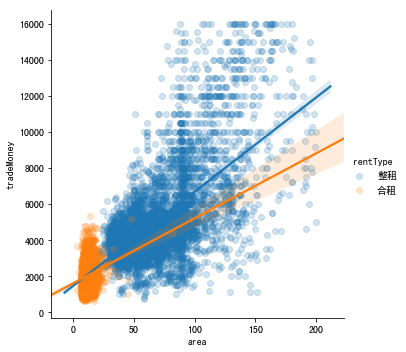

In [57]:
sns.lmplot('area', 'tradeMoney', data=SVM_train, hue='rentType', scatter_kws={'alpha':0.2})

In [69]:
SVM_test_y = []
n = 0
for i in range(y.size):
    if y[i] == 1:
        SVM_test_y.append("整租")
    else:
        SVM_test_y.append("合租")
        n += 1
        
SVM_test['rentType'] = SVM_test_y
SVM_test.head()

,id,area,tradeMoney,Room,Room_Bath,rentType
0,0,68.06,2000.0,2,0.666667,整租
1,1,125.55,2000.0,3,0.750000,整租
2,2,132.00,16000.0,3,0.750000,整租
3,3,57.00,1600.0,1,1.000000,整租
4,4,129.00,2900.0,3,1.000000,整租


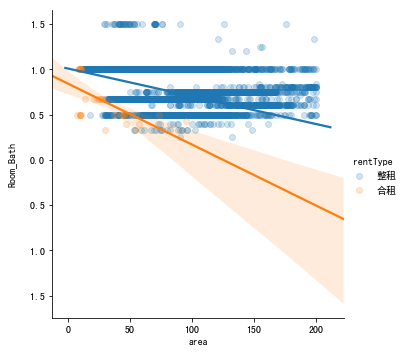

In [73]:
sns.lmplot('area', 'Room_Bath', data=SVM_test, hue='rentType', scatter_kws={'alpha':0.2})

In [153]:
def SVM_RentType(train):
    train['Room'] = train['houseType'].apply(lambda x: x.split('室')[0]).astype('int')
    train['Hall'] = train['houseType'].apply(lambda x: x.split('室')[1].split('厅')[0]).astype('int') 
    train['Bath'] = train['houseType'].apply(lambda x: x.split("室")[1].split("厅")[1].split("卫")[0]).astype('int')
    train['Room_Bath'] = (train['Bath']+1) / (train['Room']+1)
    train['id'] = [i for i in range(train.shape[0])]
    
    SVM_all = pd.DataFrame(train[['id', 'area', 'Room', 'Room_Bath', 'rentType']])
    SVM_train = SVM_all[SVM_all['rentType'] != '未知方式']
    SVM_test = SVM_all[SVM_all['rentType'] == '未知方式']
    SVM_train_x = np.array(SVM_train.iloc[:,1:4])
    SVM_train_y = LabelEncoder().fit_transform(np.array(SVM_train.iloc[:,-1])).reshape(-1,1)
    SVM_test_x = np.array(SVM_test.iloc[:,1:4])
    
    # 预测rentType
    svm = SVC(kernel='rbf')
    svm.fit(SVM_train_x, SVM_train_y)
    
    SVM_test_y = []
    n = 0
    for i in range(y.size):
        if y[i] == 1:
            SVM_test_y.append("整租")
        else:
            SVM_test_y.append("合租")
#     SVM_test['rentType'] = SVM_test_y
    
    train.loc[train['rentType'] == '未知方式', 'rentType'] = SVM_test_y
    
    return train

In [157]:
train = data_train.copy()
train = SVM_RentType(train)
train.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,lookNum,tradeMoney,Type,month,day,Room,Hall,Bath,Room_Bath,id
0,68.06,整租,2室1厅1卫,低,16,暂无数据,其他,XQ00051,RG00001,BK00064,...,0,2000.0,Train,11,28,2,1,1,0.666667,0
1,125.55,整租,3室2厅2卫,中,14,暂无数据,简装,XQ00130,RG00002,BK00049,...,1,2000.0,Train,12,16,3,2,2,0.750000,1
2,132.00,整租,3室2厅2卫,低,32,暂无数据,其他,XQ00179,RG00002,BK00050,...,1,16000.0,Train,12,22,3,2,2,0.750000,2
3,57.00,整租,1室1厅1卫,中,17,暂无数据,精装,XQ00313,RG00002,BK00051,...,9,1600.0,Train,12,21,1,1,1,1.000000,3
4,129.00,整租,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,RG00003,BK00044,...,0,2900.0,Train,11,18,3,2,3,1.000000,4


In [156]:
train.rentType.value_counts()

整租    34928
合租     5232
Name: rentType, dtype: int64

In [158]:
test = data_test.copy()
# test = SVM_RentType(test)
test.rentType.value_counts()

未知方式    2185
整租       264
合租        20
Name: rentType, dtype: int64

### 数据再分析

In [13]:
train.loc[(train['Room'] <= 1), 'rentType'].value_counts()

未知方式    10223
整租       1886
合租          1
Name: rentType, dtype: int64

Room数量为1的未知方式，可以大致判断为整租

In [14]:
train.loc[(train['Room_Bath'] >= 1), 'rentType'].value_counts()

未知方式    11058
整租       2040
合租          1
Name: rentType, dtype: int64

Room_Bath大于等于1的未知方式可以大致判断为整租

In [22]:
train.loc[(train['Room'] == 2) & (train['area']<=30), 'rentType'].value_counts()

合租      205
未知方式      9
整租        3
Name: rentType, dtype: int64

Room = 2；area<=30 的未知方式可以大致判断为合租

In [23]:
train.loc[(train['Room'] == 2) & (train['area']>60), 'rentType'].value_counts()

未知方式    11212
整租       1942
合租          1
Name: rentType, dtype: int64

Room=2;area>60 的未知方式可以大致判断为整租

In [24]:
train.loc[(train['Room'] == 3) & (train['area']<=60), 'rentType'].value_counts()

合租      2739
未知方式      33
整租         7
Name: rentType, dtype: int64

In [25]:
train.loc[(train['Room'] == 3) & (train['area']>60), 'rentType'].value_counts()

未知方式    5015
整租       806
Name: rentType, dtype: int64

In [38]:
train.loc[(train['Room'] > 3) & (train['area']>=100), 'rentType'].value_counts()

未知方式    463
整租       91
Name: rentType, dtype: int64

### 整合函数

In [9]:
def FeatureEngineering(data):
    # houseType抽取信息
    data['Room'] = data['houseType'].apply(lambda x: x.split('室')[0]).astype('int')
    data['Hall'] = data['houseType'].apply(lambda x: x.split('室')[1].split('厅')[0]).astype('int')  
    data['Bath'] = data['houseType'].apply(lambda x: x.split("室")[1].split("厅")[1].split("卫")[0]).astype('int') 
    data['Room_Bath'] = (data['Bath'] + 1) / (data['Room'] + 1)
    
    # 填充租房类型
#     data = SVM_RentType(data)
    data.loc[(data['rentType'] == '未知方式') & (data['Room'] <= 1), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['Room_Bath'] >= 1), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 30) & (data['Room'] == 2), 'rentType'] = '合租'  
    data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 2), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 60) & (data['Room'] == 3), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 3), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] >= 100) & (data['Room'] > 3), 'rentType'] = '整租'
    
    # 合并部分配套设施特征
    data['trainsportNum'] = 5 * data['subwayStationNum'] / data['subwayStationNum'].mean() + data['busStationNum'] /  data['busStationNum'].mean()
                                                                                           
    data['all_SchoolNum'] = 2 * data['interSchoolNum'] / data['interSchoolNum'].mean() + data['schoolNum'] / data['schoolNum'].mean() +  data['privateSchoolNum'] / data['privateSchoolNum'].mean()                    
                            
    data['all_hospitalNum'] = 2 * data['hospitalNum'] / data['hospitalNum'].mean() + data['drugStoreNum'] / data['drugStoreNum'].mean()
                              
    data['all_mall'] = data['mallNum'] / data['mallNum'].mean() + data['superMarketNum'] / data['superMarketNum'].mean()
                       
    data['otherNum'] = data['gymNum'] / data['gymNum'].mean() + data['bankNum'] / data['bankNum'].mean() + \
                       data['shopNum'] / data['shopNum'].mean() + 2 * data['parkNum'] / data['parkNum'].mean()

    data.drop(['subwayStationNum', 'busStationNum',
               'interSchoolNum', 'schoolNum', 'privateSchoolNum',
               'hospitalNum', 'drugStoreNum', 'mallNum', 'superMarketNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum'],
              axis=1, inplace=True)
    
    data.drop('houseType', axis=1, inplace=True)
    
    return data

In [10]:
train = data_train.copy()
train = FeatureEngineering(train)
train.head()

,area,rentType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,buildYear,...,day,Room,Hall,Bath,Room_Bath,trainsportNum,all_SchoolNum,all_hospitalNum,all_mall,otherNum
0,68.06,整租,低,16,暂无数据,其他,XQ00051,RG00001,BK00064,1953,...,28,2,1,1,0.666667,6.275037,0.737932,0.668656,0.743777,2.248989
1,125.55,整租,中,14,暂无数据,简装,XQ00130,RG00002,BK00049,2007,...,16,3,2,2,0.750000,2.715433,0.537518,0.926687,1.250888,2.533730
2,132.00,整租,低,32,暂无数据,其他,XQ00179,RG00002,BK00050,1994,...,22,3,2,2,0.750000,5.533376,2.557156,1.799543,0.999678,3.517197
3,57.00,整租,中,17,暂无数据,精装,XQ00313,RG00002,BK00051,1994,...,21,1,1,1,1.000000,4.540501,4.099596,5.125620,1.727274,3.853554
4,129.00,整租,低,2,暂无数据,毛坯,XQ01257,RG00003,BK00044,1994,...,18,3,2,3,1.000000,0.748825,0.310106,0.361244,0.727124,1.934415


In [13]:
test = data_test.copy()
test = FeatureEngineering(test)
test.head()

,area,rentType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,buildYear,...,day,Room,Hall,Bath,Room_Bath,trainsportNum,all_SchoolNum,all_hospitalNum,all_mall,otherNum
0,36.54,整租,高,21,西北,其他,XQ03867,RG00012,BK00013,2008,...,25,1,1,1,1.000000,3.788256,5.545572,4.332163,0.892137,4.635644
1,64.00,整租,高,11,南北,其他,XQ00821,RG00002,BK00055,2009,...,19,2,1,1,0.666667,10.132852,1.276564,4.055809,1.844215,4.801505
2,98.00,整租,高,6,暂无数据,精装,XQ00842,RG00002,BK00055,1996,...,4,3,1,1,0.500000,10.132852,1.276564,4.055809,1.844215,4.801505
3,43.45,整租,高,6,暂无数据,其他,XQ00786,RG00002,BK00055,1994,...,3,1,1,1,1.000000,10.132852,1.276564,4.055809,1.844215,4.801505
4,92.00,整租,高,6,暂无数据,其他,XQ01201,RG00002,BK00062,2004,...,14,2,2,1,0.666667,5.377752,3.409058,1.371388,2.436830,4.902879


In [14]:
print('train shape: ',train.shape,'\n', 'test shape: ',test.shape)

train shape:  (40160, 46) 
 test shape:  (2469, 45)


### 计算统计特征

In [15]:
def featureCount(train,test):
    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
    
    def feature_count(data, features=[]):
        new_feature = 'count'
        for i in features:
            new_feature += '_' + i
        temp = data.groupby(features).size().reset_index().rename(columns={0: new_feature})
        data = data.merge(temp, 'left', on=features)
        return data

    data = feature_count(data, ['communityName'])
    data = feature_count(data, ['buildYear'])
    data = feature_count(data, ['totalFloor'])
    data = feature_count(data, ['communityName', 'totalFloor'])
    data = feature_count(data, ['communityName', 'newWorkers'])
    data = feature_count(data, ['communityName', 'totalTradeMoney'])
    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type'], axis=1, inplace=True)
    return new_train, new_test

In [16]:
train, test = featureCount(train, test)
train.head()

,Bath,Hall,Room,Room_Bath,Type,all_SchoolNum,all_hospitalNum,all_mall,area,buildYear,...,tradeNewNum,tradeSecNum,trainsportNum,uv,count_communityName,count_buildYear,count_totalFloor,count_communityName_totalFloor,count_communityName_newWorkers,count_communityName_totalTradeMoney
0,1,1,2,0.666667,Train,0.737932,0.668656,0.743777,68.06,1953,...,25,111,6.275037,284,6,83,1168,4,1,1
1,2,2,3,0.750000,Train,0.537518,0.926687,1.250888,125.55,2007,...,2,2,2.715433,22,11,1840,2251,7,1,1
2,2,2,3,0.750000,Train,2.557156,1.799543,0.999678,132.00,1994,...,11,555,5.533376,20,25,5847,220,12,2,2
3,1,1,1,1.000000,Train,4.099596,5.125620,1.727274,57.00,1994,...,58,260,4.540501,279,60,5847,1394,35,3,3
4,3,2,3,1.000000,Train,0.310106,0.361244,0.727124,129.00,1994,...,34,38,0.748825,480,15,5847,62,4,2,2


In [17]:
test.head()

,Bath,Hall,Room,Room_Bath,Type,all_SchoolNum,all_hospitalNum,all_mall,area,buildYear,...,tradeNewNum,tradeSecNum,trainsportNum,uv,count_communityName,count_buildYear,count_totalFloor,count_communityName_totalFloor,count_communityName_newWorkers,count_communityName_totalTradeMoney
40160,1,1,1,1.000000,Test,5.545572,4.332163,0.892137,36.54,2008,...,0,187,3.788256,397,4,1884,467,4,1,1
40161,1,1,2,0.666667,Test,1.276564,4.055809,1.844215,64.00,2009,...,170,252,10.132852,3066,7,1249,2974,6,7,2
40162,1,1,3,0.500000,Test,1.276564,4.055809,1.844215,98.00,1996,...,8,363,10.132852,2554,23,1062,16816,23,15,4
40163,1,1,1,1.000000,Test,1.276564,4.055809,1.844215,43.45,1994,...,12,162,10.132852,2016,7,5847,16816,7,6,1
40164,1,2,2,0.666667,Test,3.409058,1.371388,2.436830,92.00,2004,...,46,137,5.377752,2957,11,1441,16816,11,11,5


In [18]:
print('train shape: ',train.shape,'\n', 'test shape: ',test.shape)

train shape:  (40160, 52) 
 test shape:  (2469, 52)


### grouby方法生成统计特征

In [19]:
def groupby(train,test):
    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
    for feature in columns:
        data[feature] = LabelEncoder().fit_transform(data[feature])

    temp = data.groupby('communityName')['area'].agg({'com_area_mean': 'mean', 'com_area_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='communityName', how='left')
    
    data['price_per_area'] = data.tradeMeanPrice / data.area * 100
    temp = data.groupby('communityName')['price_per_area'].agg(
        {'comm_price_mean': 'mean', 'comm_price_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='communityName', how='left')
   
    temp = data.groupby('plate')['price_per_area'].agg(
        {'plate_price_mean': 'mean', 'plate_price_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='plate', how='left')
    data.drop('price_per_area', axis=1, inplace=True)

    temp = data.groupby('plate')['area'].agg({'plate_area_mean': 'mean', 'plate_area_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='plate', how='left')
    
    temp = data.groupby(['plate'])['buildYear'].agg({'plate_year_mean': 'mean', 'plate_year_std': 'std'})
    data = data.merge(temp, on='plate', how='left')
    data.plate_year_mean = data.plate_year_mean.astype('int')
    data['comm_plate_year_diff'] = data.buildYear - data.plate_year_mean
    data.drop('plate_year_mean', axis=1, inplace=True)

    temp = data.groupby('plate')['trainsportNum'].agg('sum').reset_index(name='plate_trainsportNum')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['trainsportNum'].agg('sum').reset_index(name='com_trainsportNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data['trainsportNum_ratio'] = list(map(lambda x, y: round(x / y, 3) if y != 0 else -1,
                                           data['com_trainsportNum'], data['plate_trainsportNum']))
    data = data.drop(['com_trainsportNum', 'plate_trainsportNum'], axis=1)

    temp = data.groupby('plate')['all_SchoolNum'].agg('sum').reset_index(name='plate_all_SchoolNum')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['all_SchoolNum'].agg('sum').reset_index(name='com_all_SchoolNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data = data.drop(['com_all_SchoolNum', 'plate_all_SchoolNum'], axis=1)

    temp = data.groupby(['communityName', 'plate'])['all_mall'].agg('sum').reset_index(name='com_all_mall')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')

    temp = data.groupby('plate')['otherNum'].agg('sum').reset_index(name='plate_otherNum')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['otherNum'].agg('sum').reset_index(name='com_otherNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data['other_ratio'] = list(map(lambda x, y: round(x / y, 3) if y != 0 else -1,
                                   data['com_otherNum'], data['plate_otherNum']))
    data = data.drop(['com_otherNum', 'plate_otherNum'], axis=1)

    temp = data.groupby(['month', 'communityName']).size().reset_index(name='communityName_saleNum')
    data = data.merge(temp, on=['month', 'communityName'], how='left')
    temp = data.groupby(['month', 'plate']).size().reset_index(name='plate_saleNum')
    data = data.merge(temp, on=['month', 'plate'], how='left')

    data['sale_ratio'] = round((data.communityName_saleNum + 1) / (data.plate_saleNum + 1), 3)
    data['sale_newworker_differ'] = 3 * data.plate_saleNum - data.newWorkers
    data.drop(['communityName_saleNum', 'plate_saleNum'], axis=1, inplace=True)

    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type'], axis=1, inplace=True)
    return new_train, new_test

In [20]:
# train = data_train.copy()
# test = data_test.copy()
# train = FeatureEngineering(train)
# test = FeatureEngineering(test)

train,test = groupby(train, test)
train.head()

,Bath,Hall,Room,Room_Bath,Type,all_SchoolNum,all_hospitalNum,all_mall,area,buildYear,...,plate_price_std,plate_area_mean,plate_area_std,plate_year_std,comm_plate_year_diff,trainsportNum_ratio,com_all_mall,other_ratio,sale_ratio,sale_newworker_differ
0,1,1,2,0.666667,Train,0.737932,0.668656,0.743777,68.06,1953,...,105283.001161,58.908155,32.428187,10.410548,-37,0.010,4.504187,0.010,0.111,-563
1,2,2,3,0.750000,Train,0.537518,0.926687,1.250888,125.55,2007,...,39929.786655,82.677900,23.737345,5.576414,-1,0.050,13.836593,0.050,0.125,-103
2,2,2,3,0.750000,Train,2.557156,1.799543,0.999678,132.00,1994,...,89898.179494,66.442601,39.750102,12.636981,3,0.025,25.047978,0.025,0.053,-352
3,1,1,1,1.000000,Train,4.099596,5.125620,1.727274,57.00,1994,...,9838.476191,82.276654,26.193596,10.585369,-6,0.046,103.772745,0.046,0.050,-1428
4,3,2,3,1.000000,Train,0.310106,0.361244,0.727124,129.00,1994,...,112664.195071,72.243053,44.540698,8.384356,-6,0.158,10.953695,0.158,0.375,-96


In [21]:
test.head()

,Bath,Hall,Room,Room_Bath,Type,all_SchoolNum,all_hospitalNum,all_mall,area,buildYear,...,plate_price_std,plate_area_mean,plate_area_std,plate_year_std,comm_plate_year_diff,trainsportNum_ratio,com_all_mall,other_ratio,sale_ratio,sale_newworker_differ
40160,1,1,1,1.000000,Test,5.545572,4.332163,0.892137,36.54,2008,...,94765.459818,51.457883,28.171699,18.009316,23,0.004,3.382422,0.005,0.033,-139
40161,1,1,2,0.666667,Test,1.276564,4.055809,1.844215,64.00,2009,...,114702.947341,66.487976,31.168388,7.642445,8,0.004,12.248661,0.004,0.021,420
40162,1,1,3,0.500000,Test,1.276564,4.055809,1.844215,98.00,1996,...,114702.947341,66.487976,31.168388,7.642445,-5,0.014,39.993848,0.014,0.016,918
40163,1,1,1,1.000000,Test,1.276564,4.055809,1.844215,43.45,1994,...,114702.947341,66.487976,31.168388,7.642445,-7,0.004,12.248661,0.004,0.019,312
40164,1,2,2,0.666667,Test,3.409058,1.371388,2.436830,92.00,2004,...,72782.850821,62.904372,30.948785,6.014341,-1,0.017,25.374082,0.017,0.031,570


In [22]:
print('train shape: ',train.shape,'\n', 'test shape: ',test.shape)

train shape:  (40160, 67) 
 test shape:  (2469, 67)


### 聚类方法

In [23]:
from sklearn.mixture import GaussianMixture

In [24]:
def cluster(train,test):
    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
    col = ['totalFloor',
           'houseDecoration', 'communityName', 'region', 'plate', 'buildYear',

           'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
           'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',

           'landTotalPrice', 'landMeanPrice', 'totalWorkers',
           'newWorkers', 'residentPopulation', 'lookNum',
           'trainsportNum',
           'all_SchoolNum', 'all_hospitalNum', 'all_mall', 'otherNum']

    # EM
    gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
    data['cluster']= pd.DataFrame(gmm.fit_predict(data[col]))


    col1 = ['totalFloor','houseDecoration', 'communityName', 'region', 'plate', 'buildYear']
    col2 = ['tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
            'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',
            'landTotalPrice', 'landMeanPrice', 'totalWorkers',
            'newWorkers', 'residentPopulation', 'lookNum',
            'trainsportNum',
            'all_SchoolNum', 'all_hospitalNum', 'all_mall', 'otherNum']
    for feature1 in col1:
        for feature2 in col2:
        
            temp = data.groupby(['cluster',feature1])[feature2].agg('mean').reset_index(name=feature2+'_'+feature1+'_cluster_mean')
            temp.fillna(0, inplace=True)
       
            data = data.merge(temp, on=['cluster', feature1], how='left')
    
   
    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type'], axis=1, inplace=True)
    
    return new_train, new_test

In [25]:
# train_cluster = data_train.copy()
# test_cluster = data_test.copy()
# train_cluster = FeatureEngineering(train_cluster)
# test_cluster = FeatureEngineering(test_cluster)

# train_cluster, test_cluster = cluster(train_cluster, test_cluster)
train, test = cluster(train, test)
train.head()

,Bath,Hall,Room,Room_Bath,Type,all_SchoolNum,all_hospitalNum,all_mall,area,buildYear,...,landMeanPrice_buildYear_cluster_mean,totalWorkers_buildYear_cluster_mean,newWorkers_buildYear_cluster_mean,residentPopulation_buildYear_cluster_mean,lookNum_buildYear_cluster_mean,trainsportNum_buildYear_cluster_mean,all_SchoolNum_buildYear_cluster_mean,all_hospitalNum_buildYear_cluster_mean,all_mall_buildYear_cluster_mean,otherNum_buildYear_cluster_mean
0,1,1,2,0.666667,Train,0.737932,0.668656,0.743777,68.06,1953,...,0.000000,193780.461538,7624.692308,241618.461538,3.538462,6.237900,3.651113,2.966328,1.499067,4.199459
1,2,2,3,0.750000,Train,0.537518,0.926687,1.250888,125.55,2007,...,790.101461,47519.215247,4568.466368,301078.412556,1.930493,5.227899,3.491430,3.114608,1.821501,4.667435
2,2,2,3,0.750000,Train,2.557156,1.799543,0.999678,132.00,1994,...,464.329320,59865.646658,2442.982054,344455.095297,1.292079,7.812780,3.665908,3.762189,2.409555,6.326753
3,1,1,1,1.000000,Train,4.099596,5.125620,1.727274,57.00,1994,...,464.329320,59865.646658,2442.982054,344455.095297,1.292079,7.812780,3.665908,3.762189,2.409555,6.326753
4,3,2,3,1.000000,Train,0.310106,0.361244,0.727124,129.00,1994,...,464.329320,59865.646658,2442.982054,344455.095297,1.292079,7.812780,3.665908,3.762189,2.409555,6.326753


In [26]:
test.head()

,Bath,Hall,Room,Room_Bath,Type,all_SchoolNum,all_hospitalNum,all_mall,area,buildYear,...,landMeanPrice_buildYear_cluster_mean,totalWorkers_buildYear_cluster_mean,newWorkers_buildYear_cluster_mean,residentPopulation_buildYear_cluster_mean,lookNum_buildYear_cluster_mean,trainsportNum_buildYear_cluster_mean,all_SchoolNum_buildYear_cluster_mean,all_hospitalNum_buildYear_cluster_mean,all_mall_buildYear_cluster_mean,otherNum_buildYear_cluster_mean
40160,1,1,1,1.000000,Test,5.545572,4.332163,0.892137,36.54,2008,...,642.261518,50856.925602,4151.345733,330146.166302,1.621444,6.539791,3.093346,3.438161,2.132600,4.819558
40161,1,1,2,0.666667,Test,1.276564,4.055809,1.844215,64.00,2009,...,1151.993716,60453.126667,4366.840000,418350.346667,1.460000,7.972601,4.100657,4.095772,3.022470,7.729286
40162,1,1,3,0.500000,Test,1.276564,4.055809,1.844215,98.00,1996,...,121.256150,82016.201044,0.000000,268729.212794,0.000000,6.194136,4.714804,2.314060,1.722650,4.404031
40163,1,1,1,1.000000,Test,1.276564,4.055809,1.844215,43.45,1994,...,310.291571,55903.950401,0.000000,282645.359348,0.000000,5.545105,4.072733,2.683934,1.940585,4.486355
40164,1,2,2,0.666667,Test,3.409058,1.371388,2.436830,92.00,2004,...,300.187643,62300.410909,0.000000,338969.463636,0.000000,6.650551,4.528128,3.372128,2.176639,5.368096


In [27]:
print('train shape: ',train.shape,'\n', 'test shape: ',test.shape)

train shape:  (40160, 176) 
 test shape:  (2469, 176)


### log平滑
过大量级值取log平滑（针对线性模型有效）

In [28]:
big_num_cols = ['totalTradeMoney','totalTradeArea','tradeMeanPrice','totalNewTradeMoney', 'totalNewTradeArea',
                'tradeNewMeanPrice','remainNewNum', 'supplyNewNum', 'supplyLandArea',
                'tradeLandArea','landTotalPrice','landMeanPrice','totalWorkers','newWorkers',
                'residentPopulation','pv','uv']
for col in big_num_cols:
        train[col] = train[col].map(lambda x: np.log1p(x))
        test[col] = test[col].map(lambda x: np.log1p(x))

In [29]:
train.head()

,Bath,Hall,Room,Room_Bath,Type,all_SchoolNum,all_hospitalNum,all_mall,area,buildYear,...,landMeanPrice_buildYear_cluster_mean,totalWorkers_buildYear_cluster_mean,newWorkers_buildYear_cluster_mean,residentPopulation_buildYear_cluster_mean,lookNum_buildYear_cluster_mean,trainsportNum_buildYear_cluster_mean,all_SchoolNum_buildYear_cluster_mean,all_hospitalNum_buildYear_cluster_mean,all_mall_buildYear_cluster_mean,otherNum_buildYear_cluster_mean
0,1,1,2,0.666667,Train,0.737932,0.668656,0.743777,68.06,1953,...,0.000000,193780.461538,7624.692308,241618.461538,3.538462,6.237900,3.651113,2.966328,1.499067,4.199459
1,2,2,3,0.750000,Train,0.537518,0.926687,1.250888,125.55,2007,...,790.101461,47519.215247,4568.466368,301078.412556,1.930493,5.227899,3.491430,3.114608,1.821501,4.667435
2,2,2,3,0.750000,Train,2.557156,1.799543,0.999678,132.00,1994,...,464.329320,59865.646658,2442.982054,344455.095297,1.292079,7.812780,3.665908,3.762189,2.409555,6.326753
3,1,1,1,1.000000,Train,4.099596,5.125620,1.727274,57.00,1994,...,464.329320,59865.646658,2442.982054,344455.095297,1.292079,7.812780,3.665908,3.762189,2.409555,6.326753
4,3,2,3,1.000000,Train,0.310106,0.361244,0.727124,129.00,1994,...,464.329320,59865.646658,2442.982054,344455.095297,1.292079,7.812780,3.665908,3.762189,2.409555,6.326753


In [30]:
test.head()

,Bath,Hall,Room,Room_Bath,Type,all_SchoolNum,all_hospitalNum,all_mall,area,buildYear,...,landMeanPrice_buildYear_cluster_mean,totalWorkers_buildYear_cluster_mean,newWorkers_buildYear_cluster_mean,residentPopulation_buildYear_cluster_mean,lookNum_buildYear_cluster_mean,trainsportNum_buildYear_cluster_mean,all_SchoolNum_buildYear_cluster_mean,all_hospitalNum_buildYear_cluster_mean,all_mall_buildYear_cluster_mean,otherNum_buildYear_cluster_mean
40160,1,1,1,1.000000,Test,5.545572,4.332163,0.892137,36.54,2008,...,642.261518,50856.925602,4151.345733,330146.166302,1.621444,6.539791,3.093346,3.438161,2.132600,4.819558
40161,1,1,2,0.666667,Test,1.276564,4.055809,1.844215,64.00,2009,...,1151.993716,60453.126667,4366.840000,418350.346667,1.460000,7.972601,4.100657,4.095772,3.022470,7.729286
40162,1,1,3,0.500000,Test,1.276564,4.055809,1.844215,98.00,1996,...,121.256150,82016.201044,0.000000,268729.212794,0.000000,6.194136,4.714804,2.314060,1.722650,4.404031
40163,1,1,1,1.000000,Test,1.276564,4.055809,1.844215,43.45,1994,...,310.291571,55903.950401,0.000000,282645.359348,0.000000,5.545105,4.072733,2.683934,1.940585,4.486355
40164,1,2,2,0.666667,Test,3.409058,1.371388,2.436830,92.00,2004,...,300.187643,62300.410909,0.000000,338969.463636,0.000000,6.650551,4.528128,3.372128,2.176639,5.368096


In [31]:
print('train shape: ',train.shape,'\n', 'test shape: ',test.shape)

train shape:  (40160, 176) 
 test shape:  (2469, 176)


## 结果对比

In [32]:
train.drop('Type', axis=1, inplace=True)
test.drop('Type', axis=1, inplace=True)
test.drop('tradeMoney', axis=1, inplace=True)

In [33]:
train.shape

(40160, 175)

In [34]:
test.shape

(2469, 174)

In [35]:
# 提取目标值
target_train = train.pop('tradeMoney') # train中的tradeMoney也被扔掉
train.shape

(40160, 174)

In [36]:
# 载入test目标值
target_test = pd.read_csv('./Data_Set/评分文件/sub_a_913.csv')
target_test.shape

(2469, 1)

### 特征工程前

In [37]:
def Obejct2Num(df):
    # 转换object
    columns = ['rentType','communityName','houseType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate']
    for feature in columns:
        df[feature] = LabelEncoder().fit_transform(df[feature])
        
    return df

In [38]:
train_before = data_train.copy()
test_before = data_test.copy()

train_before = Obejct2Num(train_before)
test_before = Obejct2Num(test_before)

train_before.drop(['Type','tradeMoney'], axis=1, inplace=True)
test_before.drop('Type', axis=1, inplace=True)

In [39]:
train_before.shape

(40160, 49)

In [40]:
test_before.shape

(2469, 49)

In [42]:
#对比特征工程前后线性模型结果情况
test=test.fillna(0)
# Lasso回归
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.1)
lasso.fit(train_before, target_train)

#预测测试集和训练集结果
y_pred_train=lasso.predict(train_before)
y_pred_test=lasso.predict(test_before)

# 对比结果
from sklearn.metrics import r2_score
score_train=r2_score(y_pred_train,target_train)
print("训练集结果：",score_train)
score_test=r2_score(y_pred_test, target_test)
print("测试集结果：",score_test)

训练集结果： 0.6399521880920426
测试集结果： 0.7003568247309877


### 特征工程过后

In [43]:
#对比特征工程前后线性模型结果情况
test=test.fillna(0)
# Lasso回归
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.1)
lasso.fit(train,target_train)
#预测测试集和训练集结果
y_pred_train=lasso.predict(train)
y_pred_test=lasso.predict(test)

#对比结果
from sklearn.metrics import r2_score
score_train=r2_score(y_pred_train,target_train)
print("训练集结果：",score_train)
score_test=r2_score(y_pred_test, target_test)
print("测试集结果：",score_test)


训练集结果： 0.7379464712167035
测试集结果： 0.8285349866247926


## ？？？？？？
经过特征过程之后，准确率更低了呢！  
真实炼丹

## 二、特征选择

### [1. 相关系数法](#1.相关系数法)     
### [2. Wrapper](#2.Wrapper)
### [3. Embedded](#3.Embedded)

### 1.相关系数法

In [74]:
# 卡方分布
from sklearn.feature_selection import SelectKBest

In [ ]:
def FSelect(train, test):
    sk=SelectKBest(k=150)
    new_train=sk.fit_transform(train,target_train)
    print(new_train.shape)
    
    # 获取对应列索引
    select_columns=sk.get_support(indices = True)
    print(select_columns)

    # 获取对应列名
#     print(test.columns[select_columns])
    select_columns_name=test.columns[select_columns]
    new_test=test[select_columns_name]
    print(new_test.shape)

### 2.Wrapper

### 3.Embedded